# Pytorch Workflow

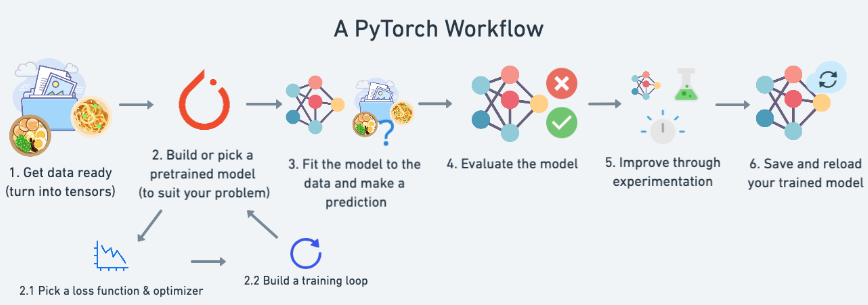

In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

plt.ion()
# Check PyTorch version
torch.__version__

'2.4.0+cu121'

# 1.데이터 준비

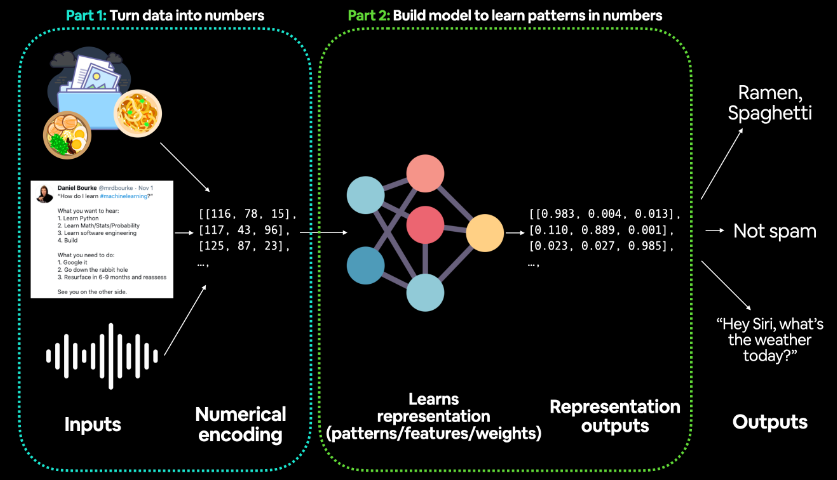

## 데이터 생성
선형 회귀식:
$$ y = weight * X + bias $$

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

In [ ]:
# Create data
start = 0
end = 1
step = 0.02
# torch.arange(start, end, step) -> [0, 0.02, 0.04, 0.06 ... ] -> (50,)
# (50,).unsqueeze(dim=1) -> (50,1)
X = torch.arange(start, end, step).unsqueeze(dim=1)
X.shape

torch.Size([50, 1])

In [ ]:
y = weight * X + bias
y.shape

torch.Size([50, 1])

In [ ]:
X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

## 데이터 분리

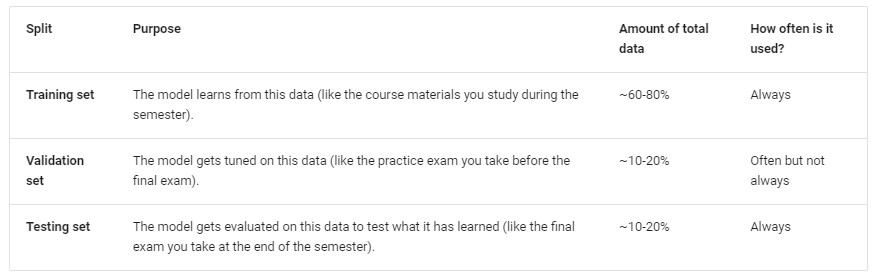

In [ ]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## 데이터 확인

In [ ]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14});

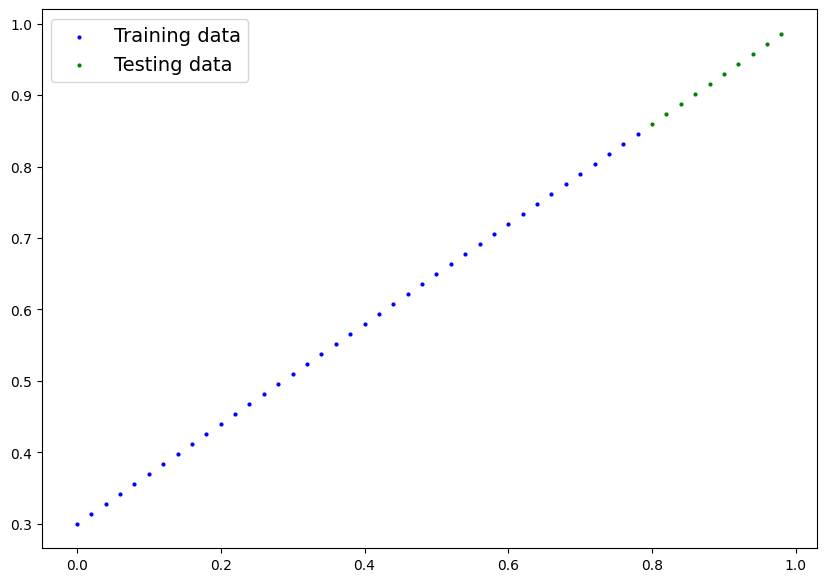

In [ ]:
plot_predictions();

# 2.모델링 정의

## 모델 정의

In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        # super().__init__() -> 부모 클래스를 인스턴스화
        super().__init__()
        # 초기 weights 생성 -> 랜덤
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                    requires_grad=True) # <- can we update this value with gradient descent?)
        # 초기 bias 생성 -> 랜덤
        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))


    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        # 선형 모델
        pred = self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)
        return pred # 선형 모델의 예측값

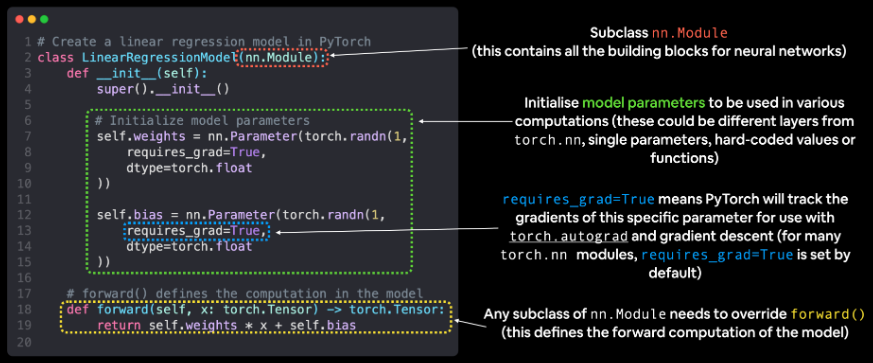

In [ ]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()
model_0

LinearRegressionModel()

In [ ]:
# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## 학습하기 전 모델 예측

In [ ]:
# Make predictions with model
# with torch.no_grad()와 의미가 같다!!!
# -> 모델의 파라미터가 변경되는 것을 방지한다.
with torch.inference_mode():
    y_preds = model_0(X_test)

In [ ]:
# Check the predictions
print(f"Number of testing samples: {len(y_test)}")
print(f"Number of predictions made: {len(y_preds)}")

Number of testing samples: 10
Number of predictions made: 10


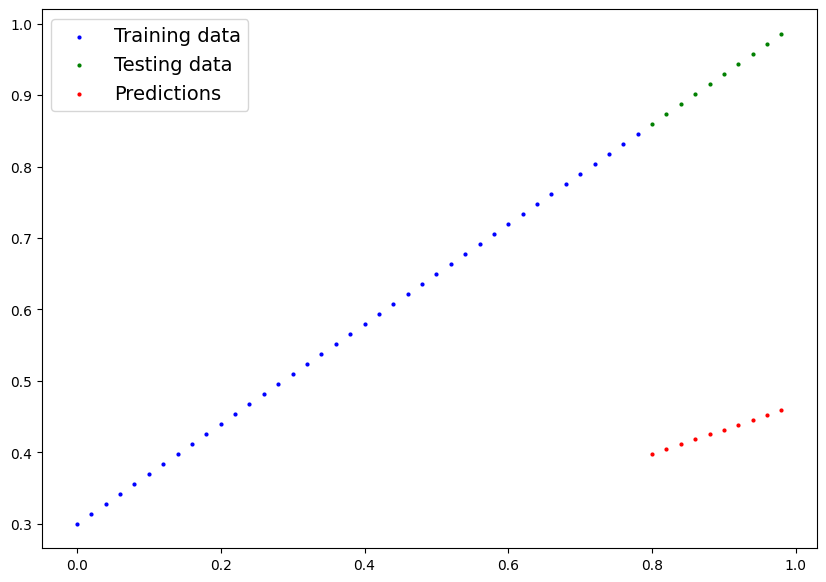

In [ ]:
plot_predictions(predictions=y_preds)

상기 그래프와 같이 모델 학습을 하기 전에는 예측과 살제가 많이 차이나는 것을 확인할 수 있다.

# 3.모델 학습

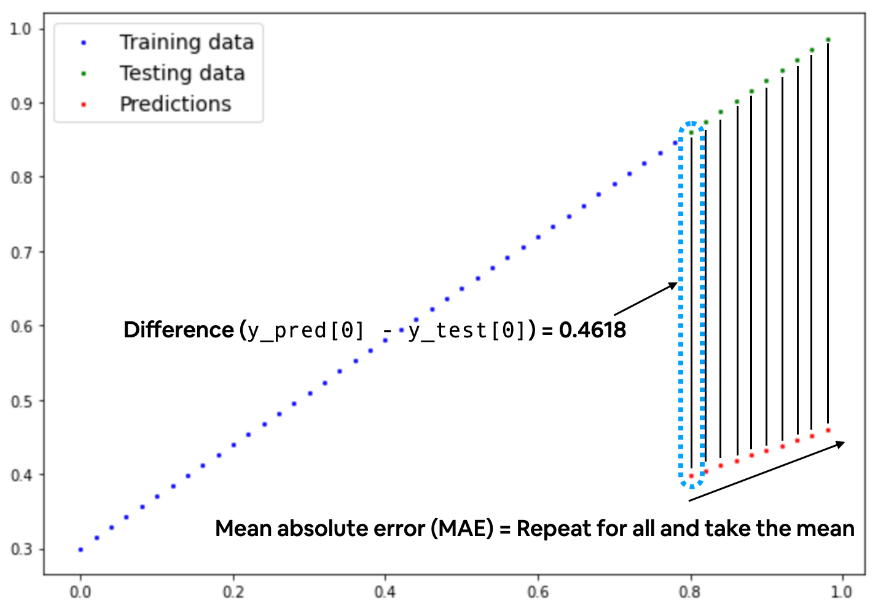

상기 그래프와 같이 실제값과 예측값의 차이를 줄이는 방향으로 모델이 학습을 하게 된다.

## Loss function & Optimizer

- Loss function: 실제값과 예측값의 차이를 계산하는 함수
- Optimizer: 모델이 학습하는 방법

### Loss function
- regression tasks
  - [nn.MSELoss(Mean Square Error)](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)
  - [nn.L1Loss(Mean Absolute Error)](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)

- binary classification tasks
  - [nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)
  - [nn.BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html):   
  combines `nn.Sigmoid` and `nn.BCELoss`

- multi classification tasks
  - [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html):   
  combines `nn.LogSoftmax` and `nn.NLLLoss`

In [ ]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss >> L2Loss(Mean Squared Error): nn.MSELoss

### [Optimization](https://pytorch.org/docs/stable/optim.html)
자주 사용하는 Optimizations:   
- [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)
- [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)

In [ ]:
# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

## 학습
- 학습전 준비물
  - 데이터: features, target
    - `train data`, `test data`
  - `lose function`
  - `Optimization`
  - `model`

### Training loop

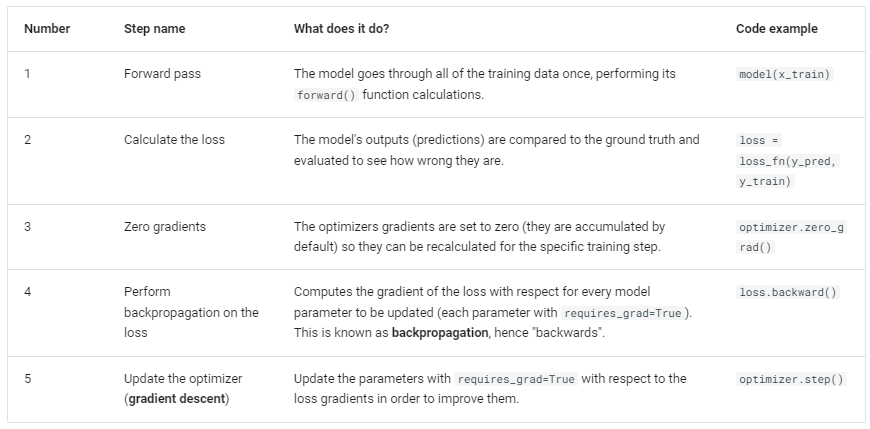

Backpropagation(역전파)
- optimizer.zero_grad()
> 역전파 단계를 실행하기 전에 변화도(gradient)를 0으로 재설정
- loss.backward()
> 역전파 단계: 모델의 학습 가능한 모든 매개변수에 대해 손실의 변화도 계산
- optimizer.step()
> 변화도를 계산한 뒤에 `optimizer.step()`을 호출하여 역전파 단계에서 수집된 변화도로 매개변수 조정

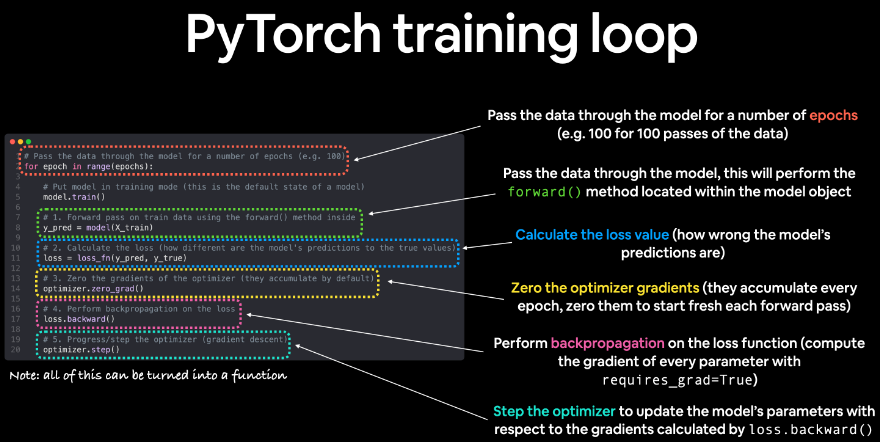

### Testing loop

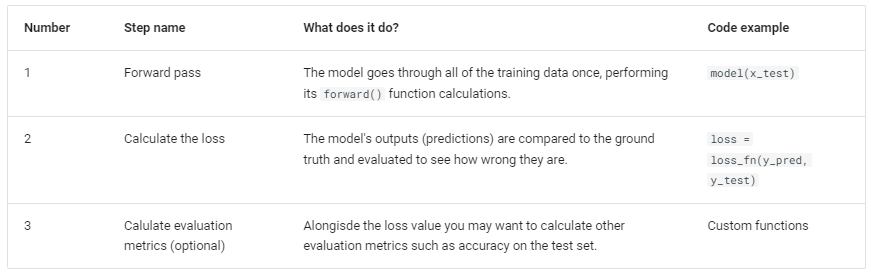

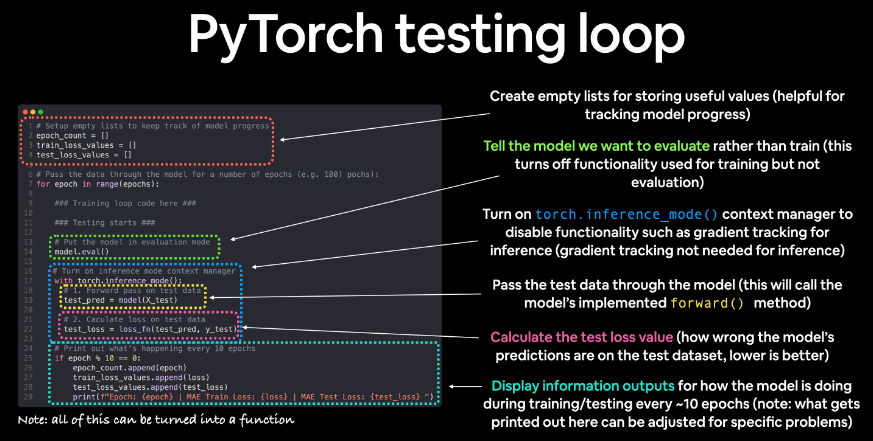

### 학습 실행(with 코드)

In [ ]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    #########################################################################
    ### Training Loop
    #########################################################################

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    #########################################################################
    ### Testing Loop
    #########################################################################

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            # loss.detach() -> loss가 들어있는 device를 cpu로 변경
            # loss.detach().numpy() -> torch를 numpy 변환
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


## 학습 결과

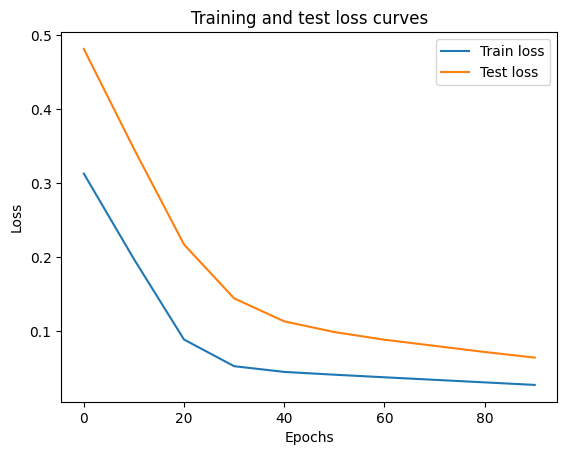

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# 4.모델 평가

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds[:5]

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603]])

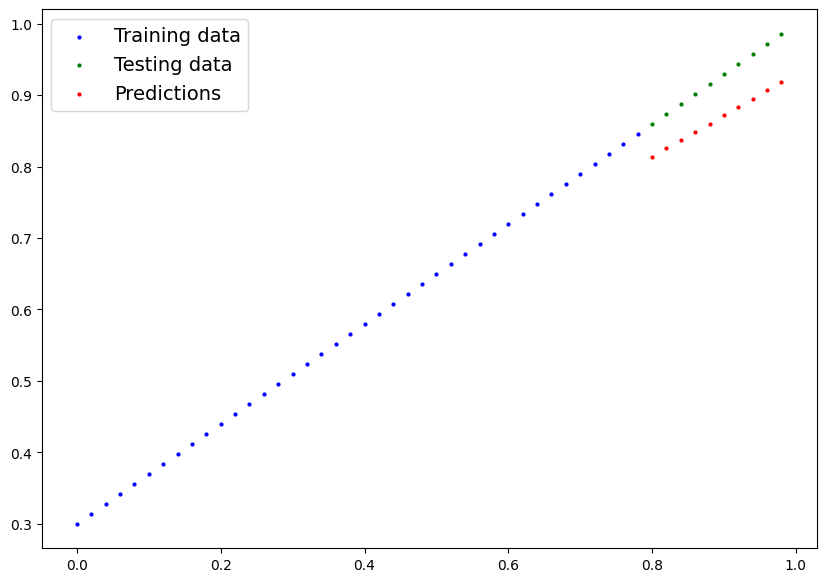

In [ ]:
plot_predictions(predictions=y_preds)

# 5.모델 저장

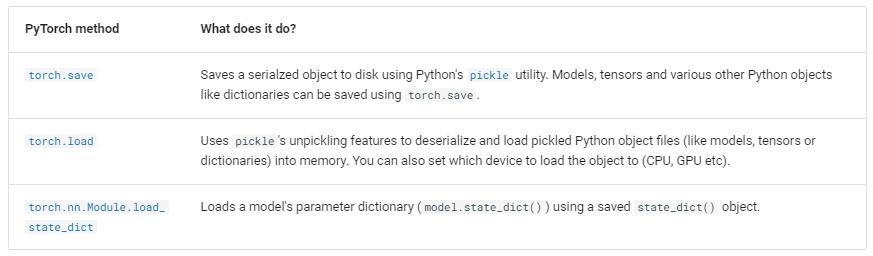

## save model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) # mkdir: make directory

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
            f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

## load model

In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
# 학습하지 않은 모델 생성
loaded_model_0 = LinearRegressionModel()
# 학습하지 않은 모델의 파라미터 확인
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
# 이미 학습된 모델의 파라미터 적용
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
# 이미 학습된 모델 파라미터 적용 확인
loaded_model_0.state_dict()

<ipython-input-27-70a8eb0a65f1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [ ]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [ ]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])